# Overview Notes

In this chapter, we are going to further expand on the following topics:
* The perceptron (artificial neuron)
* Feed forward neural networks
* **MultiLayer Perceptron (MLP)** for *image classification*
    * `TensorFlow`-based MLP for MNIST image classification
    * `Keras`-based MLP for MNIST classification
    * `TFLearn`-based MLP for MNIST classification
* MLP for time series regression

## Building up an MLP

#### 1. Simple perceptron (**Note NO weights, bias, or activation!**):

<img src="./SimplePerceptron.png"/>


#### 2. Simple perceptron with $W$ and $b$:

<img src="./SimplePerceptron_W_b.png"/>


#### 3. Simple perceptron with $W$ and $b$ and *activation* $\varphi(.)$:

<img src="./SimplePerceptron_W_b_Activation.png"/>

  * $ReLU(x)=\max(0,x): [0,x]$
  * $sigmoid(x)=\frac{1}{1-e^{-x}}: [0,1]$
  * $\tanh(x)=\frac{e^x-e^{-x}}{e^x+e^{-x}}: [-1,1]$


#### 4. This can also be shown as a simplest NN with one neuron:

<img src="./NN_One_Neuron.png"/>


#### 5. MLP:

<img src="./MLP.png"/>

* the MLP depicted in the above diagram has three features as inputs: two hidden layers of five neurons each and one output $y$. 
* The neurons are fully connected to the neurons of the next layer. 
* Such layers are also called *dense* layers or affine layers and such models are also known as *sequential models*.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#MNIST-Dataset" data-toc-modified-id="MNIST-Dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>MNIST Dataset</a></span><ul class="toc-item"><li><span><a href="#Get-the-MNIST-data" data-toc-modified-id="Get-the-MNIST-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Get the MNIST data</a></span></li><li><span><a href="#MLP-in-TensorFlow" data-toc-modified-id="MLP-in-TensorFlow-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>MLP in TensorFlow</a></span></li><li><span><a href="#MLP-in-Keras" data-toc-modified-id="MLP-in-Keras-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>MLP in Keras</a></span></li><li><span><a href="#MLP-in-TFLearn" data-toc-modified-id="MLP-in-TFLearn-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>MLP in TFLearn</a></span></li></ul></li><li><span><a href="#TimeSeries-Data---MLP---Keras" data-toc-modified-id="TimeSeries-Data---MLP---Keras-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>TimeSeries Data - MLP - Keras</a></span><ul class="toc-item"><li><span><a href="#Prepare-the-data" data-toc-modified-id="Prepare-the-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Prepare the data</a></span></li><li><span><a href="#Build,-Train-and-Evaluate-the-Model" data-toc-modified-id="Build,-Train-and-Evaluate-the-Model-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Build, Train and Evaluate the Model</a></span></li></ul></li></ul></div>

# MultiLayer Perceptron <a class="tocSkip">

In [1]:
import numpy as np
np.random.seed(123)
print("NumPy:{}".format(np.__version__))

import pandas as pd
print("Pandas:{}".format(pd.__version__))

import math
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 10
print("Matplotlib:{}".format(mpl.__version__))

import tensorflow as tf
tf.set_random_seed(123)
print("TensorFlow:{}".format(tf.__version__))

import tensorflow.keras as keras
print("Keras:{}".format(keras.__version__))

NumPy:1.18.5
Pandas:1.2.4
Matplotlib:3.3.4
TensorFlow:1.15.5
Keras:2.2.4-tf


In [2]:
DATASETSLIB_HOME = '../datasetslib'

import sys
if not DATASETSLIB_HOME in sys.path:
    sys.path.append(DATASETSLIB_HOME)

%reload_ext autoreload
%autoreload 2

import datasetslib
from datasetslib import util as dsu

In [47]:
datasetslib.datasets_root = os.path.join("../", 'datasets')

# MNIST Dataset

## Get the MNIST data

In [4]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets(
    os.path.join(datasetslib.datasets_root, 'mnist'),
    one_hot=True
)

X_train = mnist.train.images
X_test = mnist.test.images
Y_train = mnist.train.labels
Y_test = mnist.test.labels

num_outputs = 10  # 0-9 digits
num_inputs = 784  # total pixels (28*28)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /home/essav/datasets/mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /home/essav/datasets/mnist/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /home/essav/datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/essav/datasets/mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [5]:
print("type(X_train):", type(X_train))
print("type(Y_test):", type(Y_test))
print("X_train.shape:", X_train.shape)
print("Y_test.shape:", Y_test.shape)

type(X_train): <class 'numpy.ndarray'>
type(Y_test): <class 'numpy.ndarray'>
X_train.shape: (55000, 784)
Y_test.shape: (10000, 10)


tf.reset_default_graph()## MLP in TensorFlow

In [20]:
tf.reset_default_graph()

#### Note on the `mlp()` function:

Building the layers:
* The tensors are given the names `w_<layer_num>` and `b_<layer_num>` respectively. Naming the tensors helps in the debugging and locating problems with the code.
* The tensors are initialized with normal distribution using `tf.random_normal()`.
* The *first* dimension of the weight tensor is the number of inputs from the previous layer. 
    * For the first hidden layer, the first dimension is `num_inputs`. 
* The *second* dimension of the weights tensor is the number of neurons in the current layer.
* The biases are all one-dimensional tensors, where the dimension equals the number of neurons in the current layer.
* The last hidden layer: 
    * In this case, the dimensions of the weights tensor are equal to the number of neurons in the last hidden layer and the *number of output targets*. 
    * The bias would be a tensor having a single dimension of the size of the *number of output features*.

In [21]:
# Function to **build** an MLP model.

def mlp(
    x,            # x is the input features tensor
    num_inputs,   # num_inputs is the number of input features
    num_outputs,  # num_outputs is the number of output targets
    num_layers,   # num_layers is the number of hidden layers required
    num_neurons   # num_neurons is the **list** containing the number of neurons for each layer
):
    print("========== BUILDING MODEL ==========")
    w = []  # Create a LIST to store W's for each layer
    b = []  # Create a LIST to store b's for each layer
    
    # Run a loop for the number of hidden layers to create weights and bias tensors
    # and append them to their respective lists:
    for i in range(num_layers):
        # Weights
        w.append(
            # Define a `Variable`...
            tf.Variable(
                # Initial value set via `random_normal()`
                tf.random_normal(
                    # Shape: 
                    #   - set to [num_inputs, num_neurons[i]] for 0th hidden layer, 
                    #   - set to [num_neurons[i - 1], num_neurons[i]] for other hidden layers.
                    shape=[
                        num_inputs if i == 0 else num_neurons[i - 1],  # shape[0]
                        num_neurons[i]                                 # shape[1]
                    ]
                ),
                name="w_{0:04d}".format(i)
            )
        )
        print(f"Added W layer [{i}]: {w[i]}")
        # Biases
        b.append(
            tf.Variable(
                tf.random_normal(
                    [num_neurons[i]]
                ),
                name="b_{0:04d}".format(i)
            )
        )
        print(f"Added b layer [{i}]: {b[i]}")
    
    # Set up the *last* (output) layer:
    # Weights:
    w.append(
        tf.Variable(
            tf.random_normal(
                [
                    num_neurons[num_layers - 1] if num_layers > 0 else num_inputs,  # shape[0] 
                    num_outputs                                                     # shape[1]
                ]
            ), 
            name="w_out"
        )
    )
    print(f"Added W layer [*output*]: {w[-1]}")
    # Biases:
    b.append(
        tf.Variable(
            tf.random_normal([num_outputs]), 
            name="b_out"
        )
    )
    print(f"Added b layer [*output*]: {b[-1]}")
    
    # Define the model computation graph:
    # `x` is input layer:
    layer = x
    # Add hidden layers:
    for i in range(num_layers):
        layer = tf.nn.relu(tf.matmul(layer, w[i]) + b[i])  # ReLU( W*x + b )
    # Add output layer:
    layer = tf.matmul(layer, w[num_layers]) + b[num_layers]  # W*x + b (no ReLU on last layer)
    
    print("========== BUILDING MODEL FINISHED ==========")
    return layer

In [22]:
def mnist_batch_func(batch_size=100):
    X_batch, Y_batch = mnist.train.next_batch(batch_size)
    return X_batch, Y_batch

In [23]:
# Helper for the whole classification pipeline.

def tensorflow_classification(
    n_epochs, 
    n_batches,
    batch_size, 
    batch_func,
    model, 
    optimizer, 
    loss, 
    accuracy_function,
    X_test, 
    Y_test
):
    # Debug info for my own satisfaction: ----------
    _args = [
        ("n_epochs", n_epochs), 
        ("n_batches", n_batches),
        ("batch_size", batch_size), 
        ("batch_func", batch_func),
        ("model", model), 
        ("optimizer", optimizer), 
        ("loss", loss), 
        ("accuracy_function", accuracy_function),
        ("X_test", X_test), 
        ("Y_test", Y_test),
    ]
    for _name, _arg in _args:
        print(f"<{_name}>:\ntype: {type(_arg)}\n{_arg}")
        if "shape" in dir(_arg):
            print(f"shape: {_arg.shape}")
        print("-" * 80)
    # ----------------------------------------------
    
    with tf.Session() as tfs:
        tfs.run(tf.global_variables_initializer())
        
        # Epoch iteration:
        for epoch in range(n_epochs):
            epoch_loss = 0.0
            
            # Batch iteration:
            for batch in range(n_batches):
                X_batch, Y_batch = batch_func(batch_size)
                feed_dict = {x: X_batch, y: Y_batch}
                _, batch_loss = tfs.run([optimizer, loss], feed_dict)
                epoch_loss += batch_loss  # NOTE: Accummulating epoch loss!
            
            average_loss = epoch_loss / n_batches
            print("epoch: {0:04d}   TRAINING loss = {1:0.6f}".format(epoch, average_loss))
        
        # Final accuracy, on the test set.
        feed_dict = {x: X_test, y: Y_test}
        accuracy_score = tfs.run(accuracy_function, feed_dict=feed_dict)
        print("TEST accuracy={0:.8f}".format(accuracy_score))

### Case 1: No hidden layers.

In [24]:
num_layers = 0
num_neurons = []

In [25]:
learning_rate = 0.01
n_epochs = 50
batch_size = 100
n_batches = int(mnist.train.num_examples / batch_size)
print(f"batch size: {batch_size}    n_batches: {n_batches}")

batch size: 100    n_batches: 550


In [26]:
# Input images:
x = tf.placeholder(dtype=tf.float32, name="x", shape=[None, num_inputs])
# Target output:
y = tf.placeholder(dtype=tf.float32, name="y", shape=[None, num_outputs])

In [27]:
# Build model.
model = mlp(
    x=x,
    num_inputs=num_inputs,
    num_outputs=num_outputs,
    num_layers=num_layers,
    num_neurons=num_neurons
)

========== BUILDING MODEL ==========
Added W layer [*output*]: <tf.Variable 'w_out:0' shape=(784, 10) dtype=float32_ref>
Added b layer [*output*]: <tf.Variable 'b_out:0' shape=(10,) dtype=float32_ref>
========== BUILDING MODEL FINISHED ==========


#### Note on `tf.nn.softmax_cross_entropy_with_logits()`
* When the `softmax_cross_entropy_with_logits()` function is used, make sure that the output is **unscaled** and has **not** been passed through the `softmax` activation function. 
* This function internally uses softmax to scale the output.
* This function computes the softmax entropy between the model (the estimated value y) and the actual value of $y$. 
    * The entropy function is used when the output belongs to one class and not more than one class. 
    * As in our example, the image can only belong to one of the digits.

In [28]:
# Define loss function:
loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=y)
)

In [29]:
# Define optimizer function:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

In [30]:
# Define (test) accuracy metric function:
predictions_check = tf.equal(tf.argmax(model, axis=1), tf.argmax(y, axis=1))
accuracy_function = tf.reduce_mean(tf.cast(predictions_check, tf.float32))

In [31]:
# Execute classification pipeline!
tensorflow_classification(
    n_epochs=n_epochs,
    n_batches=n_batches,
    batch_size=batch_size,
    batch_func=mnist_batch_func,
    model=model,
    optimizer=optimizer,
    loss=loss,
    accuracy_function=accuracy_function,
    X_test=mnist.test.images,
    Y_test=mnist.test.labels
)

<n_epochs>:
type: <class 'int'>
50
--------------------------------------------------------------------------------
<n_batches>:
type: <class 'int'>
550
--------------------------------------------------------------------------------
<batch_size>:
type: <class 'int'>
100
--------------------------------------------------------------------------------
<batch_func>:
type: <class 'function'>
<function mnist_batch_func at 0x7fe388e64320>
--------------------------------------------------------------------------------
<model>:
type: <class 'tensorflow.python.framework.ops.Tensor'>
Tensor("add:0", shape=(?, 10), dtype=float32)
shape: (?, 10)
--------------------------------------------------------------------------------
<optimizer>:
type: <class 'tensorflow.python.framework.ops.Operation'>
name: "GradientDescent"
op: "NoOp"
input: "^GradientDescent/update_w_out/ApplyGradientDescent"
input: "^GradientDescent/update_b_out/ApplyGradientDescent"

------------------------------------------------

### Case 2: 1 Hiden Layer

In [32]:
tf.reset_default_graph()

In [33]:
num_layers = 1 
num_neurons = []
for i in range(num_layers):
    num_neurons.append(8)
    
learning_rate = 0.01
n_epochs = 50
batch_size = 100
n_batches = int(mnist.train.num_examples/batch_size)

# input images
x = tf.placeholder(dtype=tf.float32, name="x", shape=[None, num_inputs]) 
# target output
y = tf.placeholder(dtype=tf.float32, name="y", shape=[None, num_outputs]) 

model = mlp(
    x=x, 
    num_inputs=num_inputs, 
    num_outputs=num_outputs, 
    num_layers=num_layers, 
    num_neurons=num_neurons
)

# loss function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=y))
# optimizer function
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

# accuracy
predictions_check = tf.equal(tf.argmax(model,1), tf.argmax(y,1))
accuracy_function = tf.reduce_mean(tf.cast(predictions_check, tf.float32))

tensorflow_classification(
    n_epochs=n_epochs, 
    n_batches=n_batches, 
    batch_size=batch_size, 
    batch_func=mnist_batch_func, 
    model = model, 
    optimizer = optimizer, 
    loss = loss, 
    accuracy_function = accuracy_function, 
    X_test = mnist.test.images, 
    Y_test = mnist.test.labels
)

========== BUILDING MODEL ==========
Added W layer [0]: <tf.Variable 'w_0000:0' shape=(784, 8) dtype=float32_ref>
Added b layer [0]: <tf.Variable 'b_0000:0' shape=(8,) dtype=float32_ref>
Added W layer [*output*]: <tf.Variable 'w_out:0' shape=(8, 10) dtype=float32_ref>
Added b layer [*output*]: <tf.Variable 'b_out:0' shape=(10,) dtype=float32_ref>
========== BUILDING MODEL FINISHED ==========
<n_epochs>:
type: <class 'int'>
50
--------------------------------------------------------------------------------
<n_batches>:
type: <class 'int'>
550
--------------------------------------------------------------------------------
<batch_size>:
type: <class 'int'>
100
--------------------------------------------------------------------------------
<batch_func>:
type: <class 'function'>
<function mnist_batch_func at 0x7fe388e64320>
--------------------------------------------------------------------------------
<model>:
type: <class 'tensorflow.python.framework.ops.Tensor'>
Tensor("add_1:0", shap

### Case 3: 2 Hiden Layers

In [35]:
tf.reset_default_graph()

In [36]:
num_layers = 2
num_neurons = []
for i in range(num_layers):
    num_neurons.append(256)
    
learning_rate = 0.01
n_epochs = 50
batch_size = 100
n_batches = int(mnist.train.num_examples/batch_size)

# input images
x = tf.placeholder(dtype=tf.float32, name="x", shape=[None, num_inputs]) 
# target output
y = tf.placeholder(dtype=tf.float32, name="y", shape=[None, num_outputs]) 

model = mlp(
    x=x, 
    num_inputs=num_inputs, 
    num_outputs=num_outputs, 
    num_layers=num_layers, 
    num_neurons=num_neurons
)

# loss function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=y))
# optimizer function
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

# accuracy
predictions_check = tf.equal(tf.argmax(model,1), tf.argmax(y,1))
accuracy_function = tf.reduce_mean(tf.cast(predictions_check, tf.float32))

tensorflow_classification(
    n_epochs=n_epochs, 
    n_batches=n_batches, 
    batch_size=batch_size, 
    batch_func=mnist_batch_func, 
    model = model, 
    optimizer = optimizer, 
    loss = loss, 
    accuracy_function = accuracy_function, 
    X_test = mnist.test.images, 
    Y_test = mnist.test.labels
)

========== BUILDING MODEL ==========
Added W layer [0]: <tf.Variable 'w_0000:0' shape=(784, 256) dtype=float32_ref>
Added b layer [0]: <tf.Variable 'b_0000:0' shape=(256,) dtype=float32_ref>
Added W layer [1]: <tf.Variable 'w_0001:0' shape=(256, 256) dtype=float32_ref>
Added b layer [1]: <tf.Variable 'b_0001:0' shape=(256,) dtype=float32_ref>
Added W layer [*output*]: <tf.Variable 'w_out:0' shape=(256, 10) dtype=float32_ref>
Added b layer [*output*]: <tf.Variable 'b_out:0' shape=(10,) dtype=float32_ref>
========== BUILDING MODEL FINISHED ==========
<n_epochs>:
type: <class 'int'>
50
--------------------------------------------------------------------------------
<n_batches>:
type: <class 'int'>
550
--------------------------------------------------------------------------------
<batch_size>:
type: <class 'int'>
100
--------------------------------------------------------------------------------
<batch_func>:
type: <class 'function'>
<function mnist_batch_func at 0x7fe388e64320>
-------

## MLP in `Keras`

In [37]:
# Note: import Keras directly from TF. 
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

In [38]:
tf.reset_default_graph()
keras.backend.clear_session()

In [39]:
# 2 Hidden layers of 256 neurons.
num_layers = 2
num_neurons = []
for i in range(num_layers):
    num_neurons.append(256)
    
learning_rate = 0.01
n_epochs = 50
batch_size = 100

model = Sequential()
model.add(
    Dense(
        units=num_neurons[0], 
        activation='relu',  # NOTE: can define activation in keras layer.
        input_shape=(num_inputs,)
    )
)
model.add(
    Dense(
        units=num_neurons[1], 
        activation='relu'
    )
)
model.add(
    Dense(
        units=num_outputs, 
        activation='softmax'
    )
)
model.summary()  # Prints model summary.

# Don't forget to compile!
model.compile(
    loss='categorical_crossentropy',  # Predefined categorical_crossentropy loss.
    optimizer=SGD(lr=learning_rate),  # Pass optimiser function.
    metrics=['accuracy']              # Predefined accuracy metric.
)

model.fit(
    X_train, 
    Y_train,
    batch_size=batch_size,
    epochs=n_epochs
)

score = model.evaluate(X_test, Y_test)  # `.evaluate()` call.
# ^ Note what this returns - in this case, it's a tuple with (loss, accuracy_metric)!
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________
Train on 55000 samples
Epoch 1/50
55000/55000 [==============================] - 1s 13us/sample - loss: 1.1096 - acc: 0.7276
Epoch 2/50
55000/55000 [==============================] - 1s 12us/sample - loss: 0.4487 - acc: 0.8798
Epoch 3/50
55000/55000 [==============================] - 1s 13us/sample

## MLP in `TFLearn`

In [40]:
import tflearn

In [41]:
tf.reset_default_graph()

In [42]:
# 2 Hidden layers of 256 neurons.
num_layers = 2
num_neurons = []
for i in range(num_layers):
    num_neurons.append(256)

learning_rate = 0.01
n_epochs = 50
batch_size = 100

# Build deep neural network
input_layer = tflearn.input_data(shape=[None, num_inputs])
dense1 = tflearn.fully_connected(input_layer, num_neurons[0], activation='relu')
dense2 = tflearn.fully_connected(dense1, num_neurons[1], activation='relu')
softmax = tflearn.fully_connected(dense2, num_outputs, activation='softmax')

optimizer = tflearn.SGD(learning_rate=learning_rate)
# Note:
# Rather strange step in TFLearn 🤔...
# "The regression layer is used in TFLearn to apply a regression (linear or logistic) to the provided input."
net = tflearn.regression(
    softmax, 
    optimizer=optimizer, 
    metric=tflearn.metrics.Accuracy(), 
    loss='categorical_crossentropy'
)
model = tflearn.DNN(net)

model.fit(
    X_train, 
    Y_train, 
    n_epoch=n_epochs, 
    batch_size=batch_size, 
    show_metric=True, 
    run_id='dense_model'
)

score = model.evaluate(X_test, Y_test)
print('Test accuracy:', score[0])

Training Step: 27499  | total loss: 0.09476 | time: 1.321s
| SGD | epoch: 050 | loss: 0.09476 - acc: 0.9693 -- iter: 54900/55000
Training Step: 27500  | total loss: 0.09512 | time: 1.323s
| SGD | epoch: 050 | loss: 0.09512 - acc: 0.9694 -- iter: 55000/55000
--
Test accuracy: 0.9662


# TimeSeries Data - MLP - Keras

**Note**: This is time series data as converted to supervised format (shifting window)

We have seen examples of classification for image data; now let's look at regression for time series data. 

We shall build and use MLP for a smaller **univariate** time series dataset known as "the international airline passengers dataset". This dataset contains the total number of passengers over the years. The dataset is available at the following link:
* https://www.kaggle.com/andreazzini/international-airline-passengers/data


## Prepare the data

In [61]:
import os

dataframe = pd.read_csv(
    os.path.join(datasetslib.datasets_root, 'ts-data', 'international-airline-passengers.csv'), 
    usecols=[1],
    header=0
).dropna()  
# ^ Note: dropna() added by ES as had to use a "international-airline-passengers.csv" not "international-airline-passengers-cleaned.csv"

dataset = dataframe.values
dataset = dataset.astype('float32')

In [62]:
np.isnan(dataset).sum()

0

In [18]:
# normalize the dataset
# scaler = skpp.MinMaxScaler(feature_range=(0, 1))
# normalized_dataset = scaler.fit_transform(dataset)

### Note on time series (univariate, single time-series) splitting:
With a utility function from the datasetslib , we split the dataset into test and train sets. 

For time series datasets, we have a separate function that does not shuffle the observations because for time series regression we need to maintain the order of the observations.

We use 67 percent data for training and 33 percent for testing. 

You may want to try the example with a different ratio.

In [63]:
# split into train and test sets
train, test = dsu.train_test_split(dataset, train_size=0.67)
print(len(train), len(test))

96 48


In [64]:
print("train.shape", train.shape)
print("test.shape", test.shape)

train.shape (96, 1)
test.shape (48, 1)


#### Note on converting to "supervised format" of dataset.
For time series regression, we convert the dataset to build a supervised data set.

We use a **lag of two time steps** in this example. 

We set `n_x` to 2 and the `mvts_to_xy()` function returns the input and output (`X` and `Y`) train and test sets such that 
* `X` has values for time ${t-1,t}$ in two columns and 
* `Y` has values for time ${t+1}$ in one column. 

Our learning algorithm assumes that values at time $t+1$ can be learned by finding the relationship between values for time ${t-1, t, t+1}$.

In [65]:
# reshape into X=t-1,t and Y=t+1
n_x = 2
n_y = 1

X_train, Y_train, X_test, Y_test = dsu.mvts_to_xy(train, test, n_x=n_x, n_y=n_y)

In [66]:
print("X_train.shape", X_train.shape)
print("Y_train.shape", Y_train.shape)

print("X_test.shape", X_test.shape)
print("Y_test.shape", Y_test.shape)

X_train.shape (94, 2)
Y_train.shape (94, 1)
X_test.shape (46, 2)
Y_test.shape (46, 1)


## Build, Train and Evaluate the Model

In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

In [75]:
tf.reset_default_graph()
keras.backend.clear_session()

In [76]:
num_layers = 2
num_neurons = [8,8]
n_epochs = 500
batch_size = 2

model = Sequential()
model.add(Dense(num_neurons[0], activation='relu', input_shape=(n_x,)))
model.add(Dense(num_neurons[1], activation='relu'))
model.add(Dense(units=1))
model.summary()

model.compile(loss='mse', optimizer='adam')

model.fit(
    X_train, 
    Y_train,
    batch_size=batch_size,
    epochs=n_epochs,
    shuffle=False,
)

score = model.evaluate(X_test, Y_test)

print('\nTest mse:', score)
print('Test rmse:', math.sqrt(score))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________
Train on 94 samples
Epoch 1/500
94/94 [==============================] - 0s 1ms/sample - loss: 103547.5421
Epoch 2/500
94/94 [==============================] - 0s 449us/sample - loss: 59254.5534
Epoch 3/500
94/94 [==============================] - 0s 437us/sample - loss: 36409.7191
Epoch 4/500
94/94 [==============================] - 0s 409us/sample - loss: 18081.6774
Epoch 5/500
94/94

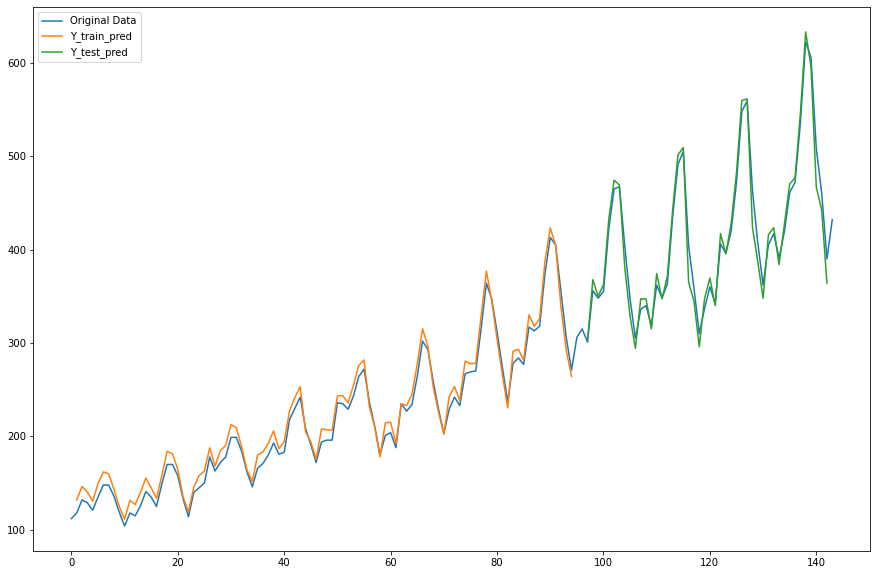

In [78]:
# Make predictions:
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# Shift train predictions for plotting:
Y_train_pred_plot = np.empty_like(dataset)
Y_train_pred_plot[:, :] = np.nan
Y_train_pred_plot[(n_x - 1):(len(Y_train_pred) + n_x - 1), :] = Y_train_pred
# ^ Note: great care needed to avoid off-by one!

# Shift test predictions for plotting:
Y_test_pred_plot = np.empty_like(dataset)
Y_test_pred_plot[:, :] = np.nan
Y_test_pred_plot[(len(Y_train_pred) + (n_x * 2) - 1):(len(dataset) - 1), :] = Y_test_pred
# ^ Note: great care needed to avoid off-by one!

# plot baseline and predictions
plt.plot(dataset,label='Original Data')
plt.plot(Y_train_pred_plot,label='Y_train_pred')
plt.plot(Y_test_pred_plot,label='Y_test_pred')
plt.legend()
plt.show()